## Required Modules

<br>

- matplotlib >= 3.1.1
- mplcursors >= 0.5.1
    - use command to install : **pip install mplcursors**
- numpy >= 1.21.5
- pandas >= 0.25.1
- sklearn >= 0.21.3

## Module Import

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors # for cursor-interactive plot. should use "%matplotlib notebook"
from sklearn.decomposition import NMF # for Non-negative Matrix Factorization
from sklearn.utils.extmath import randomized_svd # for Singular Value Decomposition
from sklearn.manifold import TSNE # for t-sne manifolding

plt.style.use('ggplot') # you can change it for your style

# just for plot checking
# %matplotlib inline

# for interactive plot
# If you use this option, plot will appear at first-drawn position.
%matplotlib notebook

warnings.filterwarnings('ignore')

## Data Loading


> ### File description : MovieLens-100K
- movies.csv : list of movies (total 9742 movies)
- ratings.csv : list of ratings given by users (610 users, 100,836 ratings)

In [3]:
dir = './MovieLens100K/'
df_ratings = pd.read_csv(dir + 'ratings.csv', usecols=['userId', 'movieId', 'rating'])
df_movies = pd.read_csv(dir + 'movies.csv', usecols=['movieId', 'title', 'genres']) # for title-matching

## Simple EDA

In [4]:
# 고유 사용자, 고유 영화 갯수 확인
n_users = len(df_ratings['userId'].unique())
n_movies = len(df_ratings['movieId'].unique())

n_users, n_movies # 610 명의 사용자가 9724개의 영화에 평점을 매김을 확인.

(610, 9724)

In [5]:
len(df_movies) # 9742 - 9724 = 18개의 영화엔 평점이 매겨지지 않음을 확인.

9742

In [6]:
# rating의 기술통계량 확인, 평점을 매기지 않은 영화는 count X.
df_ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## Make Utility Matrix $A$

> ### Step
1. Make matrix by unique movieId & userId.
2. fill NaN to 0(zero)
3. convert it to numpy array.

In [7]:
"""
A = df_ratings.pivot_table(
    values='rating',
    index='movieId',
    columns='userId'
).fillna(0).to_numpy()

"""
A = df_ratings.pivot_table(
    values='rating',
    index='movieId',
    columns='userId'
).fillna(0).to_numpy()
A.shape

(9724, 610)

In [8]:
A

array([[4. , 0. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       [4. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## Train SVD (by randomized_svd)

> ### Step
1. Get decomposed matrix U, Sigma, VT from randomized_svd.
    - See documentation : https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html
2. Compute estimated Matrix $\widehat{A_{svd}}$ by dot-producting U, Sigma, VT
    - Warning : when dot-producting, **Sigma should be diagonal matrix**.

In [9]:
# n_iter : Number of power iterations.
# When ‘auto’, it is set to 4, unless n_components is small (< .1 * min(X.shape)) in which case n_iter is set to 7. 
# This improves precision with few components.

k = 200 # number of features
U, Sigma, VT = randomized_svd(A, n_components = k, n_iter = 'auto')
U.shape, Sigma.shape, VT.shape

((9724, 200), (200,), (200, 610))

In [10]:
Sigma_diag = np.diag(Sigma)
print(Sigma_diag.shape)
# print(Sigma_diag[0][0])
for i in range(k):
    if Sigma[i] != Sigma_diag[i][i]:
        print("not matched!!!")
#     print(Sigma_diag[i][i])
    

(200, 200)


In [11]:
A_est_svd = np.dot(np.dot(U, Sigma_diag), VT)
A_est_svd.shape

(9724, 610)

## Train NMF (by NMF)

> ### Step
1. Make NMF model by NMF(), and train the model.
    - See documentation : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF
2. Get decomposed matrix W, H from trained model.
3. Compute estimated matrix $\widehat{A_{nmf}}$ by dot-producting W, H

In [12]:
k = 200
model_nmf = NMF(n_components = k, init='random', random_state=42, max_iter=100, l1_ratio=0.2)
model_nmf.fit(A)

# get decomposed matrix W, H
W = model_nmf.transform(A)
H = model_nmf.components_

# W, H shape?
W.shape, H.shape

((9724, 200), (200, 610))

In [13]:
A_est_nmf = np.dot(W, H)
A_est_nmf.shape

(9724, 610)

## Compute error with custom function

> ### Step
1. **compute_error(actual, prediction)** function gets 'Actual'(matrix), 'Prediction'(matrix) as parameter.
    1. Change actual, prediction with ignoring non-zero terms.
    2. Compute SSE and RMSE
    3. Return SSE and RMSE
2. Compute error of $A$ to $\widehat{A_{svd}}$, and $A$ to $\widehat{A_{nmf}}$
3. **compute_error_all(actual, prediction)** function gets 'Actual'(matrix), 'Prediction'(matrix) as parameter.
    1. This function calculates same as **compute_error(actual, prediction)**, but involves zero terms.

In [14]:
def compute_error(actual, prediction):
    prediction = prediction[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    sse = np.sum((actual - prediction) ** 2)
    mse = sse / len(actual)
    rmse = np.sqrt(mse)
    
    return sse, rmse

In [15]:
def compute_error_all(actual, prediction):
    sse = np.sum((actual - prediction) ** 2)
    mse = sse / len(actual)
    rmse = np.sqrt(mse)
    
    return sse, rmse

In [16]:
print(f"Error of SVD, SSE = {compute_error(A, A_est_svd)[0]}, RMSE = {compute_error(A, A_est_svd)[1]}")
print(f"Error of NMF, SSE = {compute_error(A, A_est_nmf)[0]}, RMSE = {compute_error(A, A_est_nmf)[1]}")

print('\n')

print(f"Error of SVD with 0, SSE = {compute_error_all(A, A_est_svd)[0]}, RMSE = {compute_error_all(A, A_est_svd)[1]}")
print(f"Error of NMF with 0, SSE = {compute_error_all(A, A_est_nmf)[0]}, RMSE = {compute_error_all(A, A_est_nmf)[1]}")

Error of SVD, SSE = 105987.8189934586, RMSE = 1.025227325328915
Error of NMF, SSE = 177619.27872888325, RMSE = 1.3272026687005327


Error of SVD with 0, SSE = 182411.70814639056, RMSE = 4.331156533961495
Error of NMF with 0, SSE = 228721.7888001596, RMSE = 4.849883365081159


## Make prediction for specific user's non-rated movies.

> ### Step
1. Define function **makePredictions(actual, pred, user)**, this function gets **'Actual'**(matrix), **'Prediction'**(matrix), **'userId'**(integer) as parameter.
2. Find user's ratings from **Actual** and **Prediction**. (by DataFrame)
3. Concat these two DataFrame and df_movies. (At here, we will use 'rating', 'prediction', 'title', 'genre' as columns.)
    - You can drop 'movieId' column in this function.
4. Return **actual(rated) dataframe** and **predicted (non-rated, rated by SVD, NMF) dataframe**.
    - At here, **actual(rated) dataframe should be sorted by 'rating'**.
    - And **predicted(non-rated) dataframe should be sorted by index**.
5. After finished building function, **pick one random user**, and look at rated/non-rated dataframe.
    - You should **check out both svd's prediction and nmf's prediction**.
    - Also, you should show(and look) non-rated dataframe by **head(10)**, **tail(10)**, **middle(10)**.
        - You can define middle() function (e.g. **findMiddle(dataframe)**) to find middle indexes of given dataframe.

In [21]:
# 실제 평점과 예측 평점을 확인할 수 있는 DataFrame을 생성
def makePredictions(actual, pred, user):
    user -= 1
    rated_items_df = pd.DataFrame(actual).iloc[:, user] # 해당 user index에서 rated movie(seen movies) 추출 
    user_pred_df = pd.DataFrame(pred).iloc[:, user] # 해당 user index에서 unrated movie(unseen movies) 추출
    predict_df = pd.concat([rated_items_df, user_pred_df, df_movies], axis=1) # movie dataframe과 concat. 
    predict_df.columns = ['rating', 'prediction', 'movieId', 'title', 'genre'] # 영화제목, 장르 포함 시켜서.
    # predict_df = predict_df.drop('movieId', axis=1) # 불필요한 컬럼 제거.
    
    # rated_movies : 실제로 본 영화 리스트 
    rated_movies = predict_df.where(predict_df['rating'] > 0)
    rated_movies = rated_movies.dropna()
    rated_movies = rated_movies.sort_values(by='rating', ascending=[False])
    # rated_movies = rated_movies.sort_values(by=['rating', 'movieId'], ascending=[False, True]) # 높은 평점 중 영화 이름으로 정렬.
    
    # predict_cf : 예측한 영화 리스트 (평점이 0인 영화들)
    predict_df = predict_df[predict_df['rating'] == 0]
    predict_df = predict_df.sort_index(ascending=True) # 비교를 위해 index 순서로 정렬.
    
    return rated_movies, predict_df

In [22]:
# DataFrame의 중간 지점을 반환
def findMiddle(df):
    if len(df) % 2 == 0:
        return df.iloc[int(len(df) / 2) - 5 : int(len(df) / 2) + 5]
    else:
        return df.iloc[int((len(df) / 2 - 0.5)) - 5 : int(len(df) / 2 + 0.5) + 4]

In [19]:
user_like_svd, user_predict_svd = makePredictions(A, A_est_svd, 10) # 실제 Utility Matrix와 svd를 통해 근사한 행렬 간의 비교
# user_like_nmf, user_predict_nmf = makePredictions(A, A_est_nmf, 10) # 실제 Utility Matrix와 nmf를 통해 근사한 행렬 간의 비교

In [20]:
len(user_like_svd), len(user_predict_svd)

(9742, 9584)

In [62]:
user_like_svd.head(10)

,rating,prediction,movieId,title,genre
4939,5.0,3.114776,7444,13 Going on 30 (2004),Comedy|Fantasy|Romance
5217,5.0,4.254864,8511,"Immigrant, The (1917)",Comedy
5321,5.0,2.704579,8835,Paparazzi (2004),Drama|Thriller
5901,5.0,4.359644,33615,Madagascar (2005),Adventure|Animation|Children|Comedy
6329,5.0,3.953411,48744,Shortbus (2006),Comedy|Drama|Romance
6335,5.0,3.525982,48879,Catch a Fire (2006),Drama|Thriller
7139,5.0,2.290812,71341,Blood Creek (a.k.a. Town Creek) (2009),Horror
7354,5.0,2.505475,78469,"A-Team, The (2010)",Action|Comedy|Thriller
7449,5.0,4.335107,81456,Heartbeats (Les amours imaginaires) (2010),Drama|Romance
7750,5.0,4.618347,91126,War Horse (2011),Drama|War


In [21]:
user_like_nmf.head(10)

,rating,prediction,title,genre
303,5.0,5.489808,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama
180,5.0,2.109158,Bushwhacked (1995),Adventure|Comedy|Crime|Mystery
313,5.0,2.029288,"Flintstones, The (1994)",Children|Comedy|Fantasy
413,5.0,4.999979,In the Name of the Father (1993),Drama
106,5.0,0.797338,Boomerang (1992),Comedy|Romance
37,5.0,2.296257,Richard III (1995),Drama|War
41,5.0,5.038155,To Die For (1995),Comedy|Drama|Thriller
565,5.0,2.249537,Operation Dumbo Drop (1995),Action|Adventure|Comedy|War
238,5.0,4.886645,Milk Money (1994),Comedy|Romance
173,5.0,2.056547,Unstrung Heroes (1995),Comedy|Drama


In [63]:
user_predict_svd.head(10)

,rating,prediction,movieId,title,genre
0,0.0,-1.093836,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0.0,0.651507,2,Jumanji (1995),Adventure|Children|Fantasy
2,0.0,0.437530,3,Grumpier Old Men (1995),Comedy|Romance
3,0.0,0.033542,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,0.0,-0.224988,5,Father of the Bride Part II (1995),Comedy
5,0.0,0.492503,6,Heat (1995),Action|Crime|Thriller
6,0.0,-0.192297,7,Sabrina (1995),Comedy|Romance
7,0.0,-0.153463,8,Tom and Huck (1995),Adventure|Children
8,0.0,0.054302,9,Sudden Death (1995),Action
9,0.0,0.682672,10,GoldenEye (1995),Action|Adventure|Thriller


In [23]:
user_predict_nmf.head(10)

,rating,prediction,title,genre
0,0.0,0.000000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0.0,0.000000,Jumanji (1995),Adventure|Children|Fantasy
2,0.0,0.009947,Grumpier Old Men (1995),Comedy|Romance
3,0.0,0.000000,Waiting to Exhale (1995),Comedy|Drama|Romance
4,0.0,1.053352,Father of the Bride Part II (1995),Comedy
6,0.0,0.277375,Sabrina (1995),Comedy|Romance
8,0.0,0.060184,Sudden Death (1995),Action
9,0.0,0.000000,GoldenEye (1995),Action|Adventure|Thriller
10,0.0,0.676429,"American President, The (1995)",Comedy|Drama|Romance
11,0.0,0.473389,Dracula: Dead and Loving It (1995),Comedy|Horror


In [64]:
user_predict_svd.tail(10)

,rating,prediction,movieId,title,genre
9714,0.0,-0.215101,188675,Dogman (2018),Crime|Drama
9715,0.0,-0.184372,188751,Mamma Mia: Here We Go Again! (2018),Comedy|Romance
9716,0.0,-0.245830,188797,Tag (2018),Comedy
9717,0.0,-0.245830,188833,The Man Who Killed Don Quixote (2018),Adventure|Comedy|Fantasy
9718,0.0,-0.215101,189043,Boundaries (2018),Comedy|Drama
9719,0.0,-0.245830,189111,Spiral (2018),Documentary
9720,0.0,-0.215101,189333,Mission: Impossible - Fallout (2018),Action|Adventure|Thriller
9721,0.0,-0.215101,189381,SuperFly (2018),Action|Crime|Thriller
9722,0.0,-0.215101,189547,Iron Soldier (2010),Action|Sci-Fi
9723,0.0,0.317342,189713,BlacKkKlansman (2018),Comedy|Crime|Drama


In [25]:
user_predict_nmf.tail(10)

,rating,prediction,title,genre
595,0.0,0.000000,Barb Wire (1996),Action|Sci-Fi
597,0.0,0.017143,Thinner (1996),Horror|Thriller
599,0.0,0.020919,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy
600,0.0,0.003930,"Stupids, The (1996)",Comedy
602,0.0,0.004920,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
603,0.0,0.596205,Ashes of Time (Dung che sai duk) (1994),Drama
604,0.0,0.000000,Maya Lin: A Strong Clear Vision (1994),Documentary
607,0.0,0.009029,Striptease (1996),Comedy|Crime
608,0.0,0.306678,Heavy (1995),Drama|Romance
609,0.0,0.000000,Jack (1996),Comedy|Drama


In [65]:
findMiddle(user_predict_svd)

,rating,prediction,movieId,title,genre
4826,0.0,0.003552,7202,Beyond Re-Animator (2003),Horror
4827,0.0,-0.031072,7205,"Wind and the Lion, The (1975)",Adventure
4828,0.0,0.003552,7206,Mon Oncle (My Uncle) (1958),Comedy
4829,0.0,0.009403,7208,Dr. Jekyll and Mr. Hyde (1941),Drama|Horror
4830,0.0,0.002220,7209,M. Hulot’s Holiday (Mr. Hulot's Holiday) (Vaca...,Comedy
4831,0.0,0.018525,7211,People Will Talk (1951),Comedy|Romance
4832,0.0,0.028088,7212,I Was a Male War Bride (1949),Comedy|Romance
4833,0.0,-0.005209,7215,To Have and Have Not (1944),Adventure|Drama|Romance|Thriller|War
4834,0.0,-0.030267,7216,High Sierra (1941),Crime|Drama|Film-Noir|Thriller
4835,0.0,-0.042950,7217,Dark Passage (1947),Crime|Drama|Film-Noir|Romance|Thriller


In [26]:
findMiddle(user_predict_nmf)

,rating,prediction,title,genre
298,0.0,0.070316,"War, The (1994)",Adventure|Drama|War
299,0.0,0.001279,Double Happiness (1994),Drama
300,0.0,1.034110,Muriel's Wedding (1994),Comedy
301,0.0,0.095111,"Baby-Sitters Club, The (1995)",Children
302,0.0,0.025251,Ace Ventura: Pet Detective (1994),Comedy
304,0.0,0.000000,Backbeat (1993),Drama|Musical
305,0.0,0.041274,Bitter Moon (1992),Drama|Film-Noir|Romance
306,0.0,0.003222,Bullets Over Broadway (1994),Comedy
307,0.0,0.182900,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
308,0.0,0.269063,"Client, The (1994)",Drama|Mystery|Thriller


## T-SNE for plotting embedded movies

<br>

- Decomposed matrix W from NMF, it means a **latent vector with a latent representation** for items(a.k.a movie).
    - Also decomposed matrix U from SVD means latent vector, too.
- We check how movies were embedded through NMF in latent space, and how they were clustered through **t-sne, one of the low-dimensional transformation techniques**.
    - About usage of t-sne, see documentation : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- After t-sne learns latent vector W, **low-dimensional(2-D here) transformed embedding will created**.
- Plotting those embeddings with matplotlib, check how those actual points are embedded.

In [27]:
model_tnse = TSNE(n_components = 2, init='random') # default learning rate = 200
W_embedded = model_tnse.fit(W)

In [28]:
W_embedded.embedding_.shape # 변환된 embedding의 형태는 (n_movies, 2).

(9724, 2)

- Combine those embeddings with df_movies, to match each embedding and movie information.
- Load **"Utility Matrix" (not converted to numpy array, it is dataframe)**, extract dataframe's indexes to list for combining.
- At dataframe which read 'movies.csv', **there are non-rated movies by users**. So, use above list to leave only rated movies.
    - Insert processed dataframe from above to **movie_with_embedding**.
    - When inserting, you should use **reset_index(drop=True)** option to mapping each index and embeddings exactly.
        - If not, non-matching indexes will appear, and NaN will created.
- Now, **movie_with_embedding** has only rated movies, add embeddings from W_embedded as column.
    - Since embedding has 2 columns, add each column to **movie_with_embedding** one by one as **'tsne1'**, **'tsne2'**.
    - When inserting, you need **.reshape()** method to adjust shape.

In [29]:
A2 = df_ratings.pivot_table(
    values='rating',
    index='movieId',
    columns='userId'
).fillna(0)

allList = A2.iloc[:].index.values.tolist()
movie_with_embedding = df_movies[df_movies['movieId'].isin(allList)].reset_index(drop=True)
movie_with_embedding['tsne1'] = pd.Series(W_embedded.embedding_[:, [0]].reshape(-1))
movie_with_embedding['tsne2'] = pd.Series(W_embedded.embedding_[:, [1]].reshape(-1))

In [30]:
movie_with_embedding

,movieId,title,genres,tsne1,tsne2
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,-81.966888,15.006675
1,2,Jumanji (1995),Adventure|Children|Fantasy,-84.843681,-1.673457
2,3,Grumpier Old Men (1995),Comedy|Romance,28.549873,42.167675
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,20.890760,33.597095
4,5,Father of the Bride Part II (1995),Comedy,-15.598984,61.690552
...,...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,-10.005180,-85.954735
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,-9.940294,-85.536629
9721,193585,Flint (2017),Drama,-9.940294,-85.536629
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,-9.940294,-85.536629


- Draw scatter plot using tsne1, tsne2.
- At here, we can use 'mplcursors' to **labelling to each points**. (See example code below)
    - Adjust YOUR_ANNOTATION_LIST, we can look label as 'movie name' or 'movie genre'.
    - **To use this function, '%matplotlib notebook' is required.**

    
```python
mplcursors.cursor(multiple = True).connect(
    "add", lambda sel: sel.annotation.set_text(
          YOUR_ANNOTATION_LIST[sel.target.index]
))
```

<IPython.core.display.Javascript object>


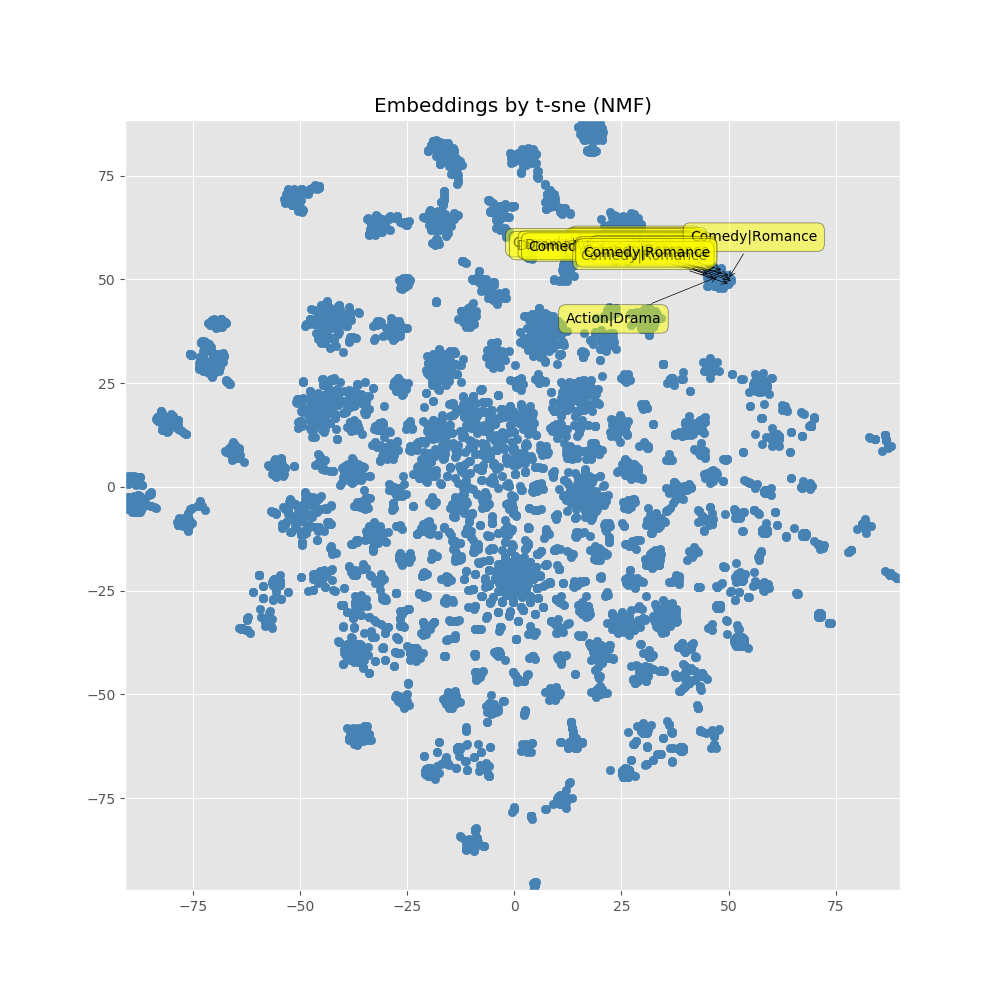

In [41]:
plt.rcParams['figure.figsize'] = [10, 10] # you can change it for your style
plt.xlim(movie_with_embedding['tsne1'].min(), movie_with_embedding['tsne1'].max()) # 범위 조정
plt.ylim(movie_with_embedding['tsne2'].min(), movie_with_embedding['tsne2'].max()) # 범위 조정

index_to_show = len(movie_with_embedding) # 원하는 수로 변경.

plt.scatter(movie_with_embedding['tsne1'][:index_to_show], movie_with_embedding['tsne2'][:index_to_show], c='steelblue')

mplcursors.cursor(multiple = True).connect(
    "add", lambda sel: sel.annotation.set_text(
          movie_with_embedding['genres'][sel.target.index]
))

plt.title('Embeddings by t-sne (NMF)')
plt.show()

## T-SNE for plotting embedded movies

<br>

- Use matrix U for comparing with W.

In [36]:
model_tnse2 = TSNE(n_components = 2, init='random') # default learning rate = 200.
U_embedded = model_tnse2.fit(U)

In [37]:
A3 = df_ratings.pivot_table(
    values='rating',
    index='movieId',
    columns='userId'
).fillna(0)

allList2 = A3.iloc[:].index.values.tolist()
movie_with_embedding2 = df_movies[df_movies['movieId'].isin(allList2)].reset_index(drop=True)
movie_with_embedding2['tsne1'] = pd.Series(U_embedded.embedding_[:, [0]].reshape(-1))
movie_with_embedding2['tsne2'] = pd.Series(U_embedded.embedding_[:, [1]].reshape(-1))

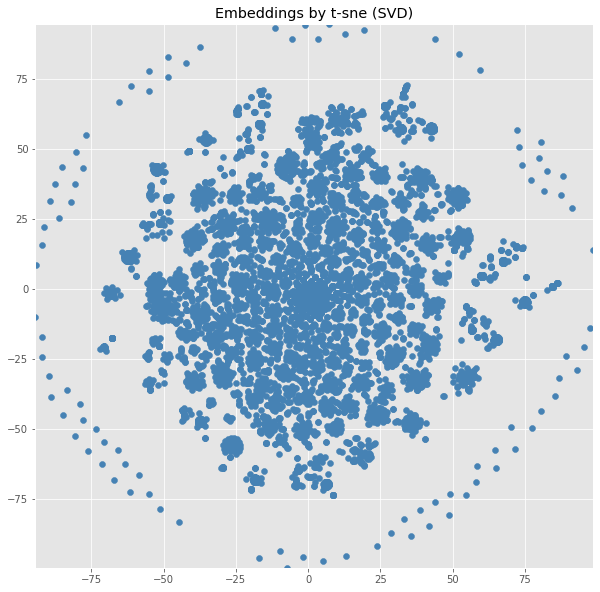

In [39]:
plt.rcParams['figure.figsize'] = [10, 10] # you can change it for your style
plt.xlim(movie_with_embedding2['tsne1'].min(), movie_with_embedding2['tsne1'].max()) # 범위 조정
plt.ylim(movie_with_embedding2['tsne2'].min(), movie_with_embedding2['tsne2'].max()) # 범위 조정

# All embeddings
index_to_show = len(movie_with_embedding2) # 원하는 수로 변경.
plt.scatter(movie_with_embedding2['tsne1'][:index_to_show], movie_with_embedding2['tsne2'][:index_to_show], c='steelblue')

mplcursors.cursor(multiple = True).connect(
    "add", lambda sel: sel.annotation.set_text(
          movie_with_embedding2['genres'][sel.target.index]
))

plt.title('Embeddings by t-sne (SVD)')
plt.show()